In [2]:
import numpy as np

from sysmexalign.alignment_1d import transform_nonnormal, mad

In [3]:
# create skewed sample data
def lognormal_pdf(x, mu=0, sigma=1):
    return (
        1
        / (x * sigma * np.sqrt(2 * np.pi))
        * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma**2))
    )


data_source = np.random.lognormal(mean=0, sigma=1, size=1000)
data_target = np.random.lognormal(mean=0, sigma=1.1, size=1000) + 5

In [4]:
mad_source = mad(data_source)
mad_target = mad(data_target)

mad_source, mad_target

(0.6470552016075963, 0.6387144383159917)

In [5]:
data_transformed = transform_nonnormal(
    data_source, np.median(data_source), np.median(data_target), mad_source, mad_target
)

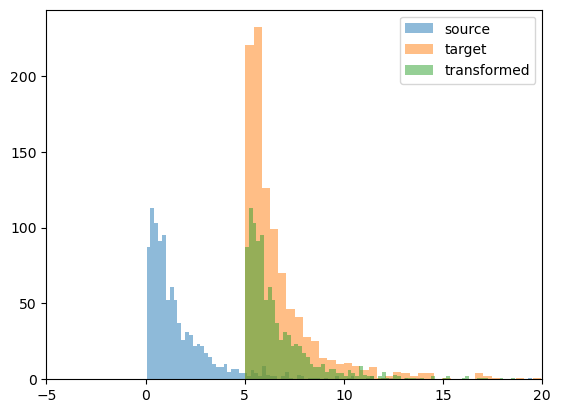

In [6]:
# plot data
import matplotlib.pyplot as plt

plt.figure()
plt.hist(data_source, bins=100, alpha=0.5, label="source")
plt.hist(data_target, bins=100, alpha=0.5, label="target")
plt.hist(data_transformed, bins=100, alpha=0.5, label="transformed")
plt.xlim(-5, 20)
plt.legend()
plt.show()

### Investigate XN_SAMPLE

In [14]:
import pandas as pd
import numpy as np

# xn = pd.read_csv(
#     "data/raw/INTERVAL_36/XN_SAMPLE.csv", encoding="ISO-8859-1", low_memory=False
# )

xn = pd.read_csv(
    "/home/dk659/bloodcounts_gitlab/sysmex_raw_alignment/data/raw/INTERVAL_36/XN_SAMPLE.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

In [15]:
# get unique entries in all columns in xn that end with "/M"
columns = [col for col in xn.columns if col.endswith("/M")]
unique_entries = set()
for col in columns:
    unique_entries.update(xn[col].unique())

unique_entries = np.unique(list(unique_entries))
unique_entries

array(['*', '+', '-', '@', 'nan'], dtype='<U32')

In [ ]:
import pandas as pd
import numpy as np


def analyze_column_types(df):
    """
    Analyzes each column in a DataFrame to determine its type:
    - Numeric (all values are numbers)
    - Binary (only two unique values)
    - Categorical (less than 10 unique values)
    - Other

    Also identifies columns that are mostly numeric but have some non-numeric entries.

    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze

    Returns:
    pandas.DataFrame: Analysis results for each column
    """
    results = []

    for col in df.columns:
        # Get column data
        col_data = df[col]
        num_values = len(col_data)
        non_null_values = col_data.count()
        null_count = num_values - non_null_values
        unique_values = col_data.nunique()

        # Check if column is numeric
        is_numeric = pd.api.types.is_numeric_dtype(col_data)

        # Check if column is mostly numeric (for string/object columns)
        mostly_numeric = False
        numeric_ratio = 0
        non_numeric_examples = []

        if not is_numeric and col_data.dtype == "object":
            # Count how many values can be converted to numeric
            numeric_count = 0
            for val in col_data.dropna().unique():
                try:
                    float(val)
                    numeric_count += 1
                except (ValueError, TypeError):
                    if len(non_numeric_examples) < 3:
                        non_numeric_examples.append(str(val))

            if len(col_data.dropna().unique()) > 0:
                numeric_ratio = numeric_count / len(col_data.dropna().unique())
                mostly_numeric = (
                    numeric_ratio > 0.8
                )  # If more than 80% of unique values are numeric

        # Check if column is entirely NaN
        if null_count == num_values:
            col_type = "Null"
        # Determine column type for non-empty columns
        elif is_numeric:
            # Check if it's a numeric column with only one unique non-NaN value
            non_null_unique = col_data.dropna().nunique()
            if non_null_unique == 1:
                col_type = "Binary"  # Only one value plus NaN
            else:
                col_type = "Numeric"
        elif unique_values == 2:
            col_type = "Binary"
        elif unique_values < 10:
            col_type = "Categorical"
        else:
            col_type = "Other"

        # Gather results
        results.append(
            {
                "Column": col,
                "Type": col_type,
                "DataType": str(col_data.dtype),
                "UniqueValues": unique_values,
                "NullValues": null_count,
                "IsNumeric": is_numeric,
                "MostlyNumeric": mostly_numeric,
                "NumericRatio": round(numeric_ratio, 2) if not is_numeric else 1.0,
                "NonNumericExamples": (
                    ", ".join(non_numeric_examples) if non_numeric_examples else ""
                ),
            }
        )

    # Create results DataFrame and sort by column name
    results_df = pd.DataFrame(results)

    return results_df


# Example usage
# xn = pd.read_csv('your_data.csv')  # Load your data
# results = analyze_column_types(xn)
# print(results)


def display_summary(results_df):
    """
    Displays a summary of the column analysis results.

    Parameters:
    results_df (pandas.DataFrame): The results from analyze_column_types
    """
    total_cols = len(results_df)
    numeric_cols = sum(results_df["IsNumeric"])
    binary_cols = sum(results_df["Type"] == "Binary")
    categorical_cols = sum(results_df["Type"] == "Categorical")
    other_cols = sum(results_df["Type"] == "Other")
    mostly_numeric_cols = sum(results_df["MostlyNumeric"])

    null_cols = sum(results_df["Type"] == "Null")

    print(f"Total columns analyzed: {total_cols}")
    print(f"Null columns (all NaN): {null_cols} ({null_cols/total_cols*100:.1f}%)")
    print(f"Numeric columns: {numeric_cols} ({numeric_cols/total_cols*100:.1f}%)")
    print(f"Binary columns: {binary_cols} ({binary_cols/total_cols*100:.1f}%)")
    print(
        f"Categorical columns: {categorical_cols} ({categorical_cols/total_cols*100:.1f}%)"
    )
    print(f"Other columns: {other_cols} ({other_cols/total_cols*100:.1f}%)")
    print(f"Mostly numeric columns with some non-numeric values: {mostly_numeric_cols}")

    if mostly_numeric_cols > 0:
        print("\nColumns that are mostly numeric but contain some non-numeric values:")
        mostly_numeric_df = results_df[
            results_df["MostlyNumeric"] & ~results_df["IsNumeric"]
        ]
        for _, row in mostly_numeric_df.iterrows():
            print(
                f"  - {row['Column']}: {row['NumericRatio']*100:.1f}% numeric, examples of non-numeric: {row['NonNumericExamples']}"
            )


# Run the analysis on your dataframe
# results = analyze_column_types(xn)
# display_summary(results)

In [ ]:
results = analyze_column_types(xn)
display_summary(results)
# print(results)  # To see the detailed analysis for each column

Total columns analyzed: 492
Null columns (all NaN): 69 (14.0%)
Numeric columns: 226 (45.9%)
Binary columns: 101 (20.5%)
Categorical columns: 119 (24.2%)
Other columns: 121 (24.6%)
Mostly numeric columns with some non-numeric values: 118

Columns that are mostly numeric but contain some non-numeric values:
  - Rack: 99.0% numeric, examples of non-numeric:       
  - Q-Flag(Abn Lymho/L-Blasts?): 94.0% numeric, examples of non-numeric: DISCRETE
  - Q-Flag(Blasts?): 96.0% numeric, examples of non-numeric: DISCRETE
  - Q-Flag(AbnLymp?): 97.0% numeric, examples of non-numeric: DISCRETE
  - Q-Flag(Atypical Lympho?): 90.0% numeric, examples of non-numeric: ERROR
  - WBC(10^3/uL): 100.0% numeric, examples of non-numeric: ----
  - RBC(10^6/uL): 100.0% numeric, examples of non-numeric: ----
  - HGB(g/dL): 99.0% numeric, examples of non-numeric: ----
  - HCT(%): 100.0% numeric, examples of non-numeric: ----
  - MCV(fL): 100.0% numeric, examples of non-numeric: ----
  - MCH(pg): 99.0% numeric, exam

In [ ]:
results

,Column,Type,DataType,UniqueValues,NullValues,IsNumeric,MostlyNumeric,NumericRatio,NonNumericExamples
0,Nickname,Null,float64,0,21996,True,False,1.00,
1,Analyzer ID,Categorical,object,1,0,False,False,0.00,XN-20^14232
2,Date,Other,object,87,0,False,False,0.00,"2021/09/30, 2021/10/01, 2021/10/02"
3,Time,Other,object,16875,0,False,False,0.00,"19:18:22, 19:19:38, 19:20:53"
4,Rack,Other,object,146,0,False,True,0.99,
...,...,...,...,...,...,...,...,...,...
487,IPF(%).1,Binary,object,2,0,False,False,0.50,----
488,IPF/M.1,Categorical,object,1,21993,False,False,0.00,*
489,IPF#(10^3/uL).1,Binary,object,2,0,False,False,0.50,----
490,IPF#/M.1,Categorical,object,1,21993,False,False,0.00,*


In [ ]:
# xn_transform_cols = list(results.loc[
#     (results["IsNumeric"] | results["MostlyNumeric"])
#     & (~results["Type"].isin(["Binary", "Null"])),
#     "Column",
# ].values)

xn_transform_cols = list(xn.columns)

In [ ]:
# drop all columns from xn_transform_cols that end in .[integer] (e.g. .1, .2, .3)
import re

xn_transform_cols = [col for col in xn_transform_cols if not re.match(r".*\.\d+$", col)]

# drop all columns beginning with "IP "
xn_transform_cols = [col for col in xn_transform_cols if not col.startswith("IP ")]

# drop all columns that end in "/M"
xn_transform_cols = [col for col in xn_transform_cols if not col.endswith("/M")]

# drop any columns that contain "Unnamed"
xn_transform_cols = [col for col in xn_transform_cols if "Unnamed" not in col]

In [ ]:
remove_cols = [
    "Nickname",
    "Analyzer ID",
    "Date",
    "Time",
    "Rack",
    "Position",
    "Sample No.",
    "Sample Inf.",
    "Order Type",
    "Reception Date",
    "Measurement Mode",
    "Discrete",
    "Patient ID",
    "Analysis Info.",
    "Judgment",
    "Positive(Diff.)",
    "Positive(Morph.)",
    "Positive(Count)",
    "Error(Func.)",
    "Error(Result)",
    "Order Info.",
    "WBC Abnormal",
    "WBC Suspect",
    "RBC Abnormal",
    "RBC Suspect",
    "PLT Abnormal",
    "PLT Suspect",
    "WBC Info.",
    "PLT Info.",
    "Rule Result",
    "Validate",
    "Validator",
    "Action Message (Check)",
    "Action Message (Review)",
    "Action Message (Retest)",
    "Sample Comment",
    "Patient Name",
    "Birth",
    "Sex",
    "Patient Comment",
    "Ward Name",
    "Doctor Name",
    "Output",
    "Sequence No.",
    "Unclassified()",
    "(Reserved)",
]

In [ ]:
xn_transform_cols = [col for col in xn_transform_cols if col not in remove_cols]

In [ ]:
xn["(Reserved)"].unique()

array([nan])

In [ ]:
xn_transform_cols

['Q-Flag(Abn Lymho/L-Blasts?)',
 'Q-Flag(Blasts?)',
 'Q-Flag(AbnLymp?)',
 'Q-Flag(Left Shift?)',
 'Q-Flag(Atypical Lympho?)',
 'Q-Flag(RBC Agglutination?)',
 'Q-Flag(Turbidity/HGB Interf?)',
 'Q-Flag(Iron Deficiency?)',
 'Q-Flag(HGB Defect?)',
 'Q-Flag(Fragments?)',
 'Q-Flag(PLT Clumps?)',
 'WBC(10^3/uL)',
 'RBC(10^6/uL)',
 'HGB(g/dL)',
 'HCT(%)',
 'MCV(fL)',
 'MCH(pg)',
 'MCHC(g/dL)',
 'PLT(10^3/uL)',
 'RDW-SD(fL)',
 'RDW-CV(%)',
 'PDW(fL)',
 'MPV(fL)',
 'P-LCR(%)',
 'PCT(%)',
 'NRBC#(10^3/uL)',
 'NRBC%(%)',
 'NEUT#(10^3/uL)',
 'LYMPH#(10^3/uL)',
 'MONO#(10^3/uL)',
 'EO#(10^3/uL)',
 'BASO#(10^3/uL)',
 'NEUT%(%)',
 'LYMPH%(%)',
 'MONO%(%)',
 'EO%(%)',
 'BASO%(%)',
 'IG#(10^3/uL)',
 'IG%(%)',
 'RET%(%)',
 'RET#(10^6/uL)',
 'IRF(%)',
 'LFR(%)',
 'MFR(%)',
 'HFR(%)',
 'RET-He(pg)',
 'IPF(%)',
 'PLT-I(10^3/uL)',
 'MicroR(%)',
 'MacroR(%)',
 'TNC(10^3/uL)',
 'WBC-N(10^3/uL)',
 'TNC-N(10^3/uL)',
 'BA-N#(10^3/uL)',
 'BA-N%(%)',
 'WBC-D(10^3/uL)',
 'TNC-D(10^3/uL)',
 'NEUT#&(10^3/uL)',
 'NEUT%

In [ ]:
len(xn_transform_cols)

227

In [ ]:
# # save list as txt file
# with open("XN_SAMPLE_transform_cols.txt", "w") as f:
#     for item in xn_transform_cols:
#         f.write("%s\n" % item)

### Investigate Impedence data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [4]:
# imp_folder = "data/raw/STRIDES/simon_batch1_part1/DIST"
# int_folder = "data/raw/INTERVAL_36/DIST"
# imp_files = os.listdir(imp_folder)
# int_files = os.listdir(int_folder)
# rbc_imp = [file for file in imp_files if file.startswith("RBC")]
# plt_imp = [file for file in imp_files if file.startswith("PLT")]
# rbc_int = [file for file in int_files if file.startswith("RBC")]
# plt_int = [file for file in int_files if file.startswith("PLT")]

# del imp_files, int_files

In [5]:
# # concatenate multiple files
# df_imp = pd.DataFrame()
# for file in rbc_imp[:50]:
#     temp = pd.read_csv(f"{imp_folder}/{file}", encoding="ISO-8859-1", low_memory=False)
#     df_imp = pd.concat([df_imp, temp], axis=0)

# df_int = pd.DataFrame()
# for file in rbc_int[:50]:
#     temp = pd.read_csv(f"{int_folder}/{file}", encoding="ISO-8859-1", low_memory=False)
#     df_int = pd.concat([df_int, temp], axis=0)

In [203]:
df_imp = pd.read_csv(
    "/home/dk659/bloodcounts_gitlab/sysmex_raw_alignment/data/raw/STRIDES/simon_batch1_part1/OutputData.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)
df_int = pd.read_csv(
    "/home/dk659/bloodcounts_gitlab/sysmex_raw_alignment/data/raw/INTERVAL_36/OutputData.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)
df_transformed = pd.read_csv(
    "/home/dk659/bloodcounts_gitlab/sysmex_raw_alignment/data/processed/STRIDES/transformed_to_INTERVAL36/OutputData.csv",
    encoding="ISO-8859-1",
    low_memory=False,
)

In [204]:
# drop all columns that don't start with "RBC_RAW_" or "PLT_RAW_"
df_imp = df_imp[
    [
        col
        for col in df_imp.columns
        if col.startswith("RBC_RAW_") or col.startswith("PLT_RAW_")
    ]
]
df_int = df_int[
    [
        col
        for col in df_int.columns
        if col.startswith("RBC_RAW_") or col.startswith("PLT_RAW_")
    ]
]
df_transformed = df_transformed[
    [
        col
        for col in df_transformed.columns
        if col.startswith("RBC_RAW_") or col.startswith("PLT_RAW_")
    ]
]

In [205]:
# sum up all rows by column for RBC_RAW_  and PLT_RAW_ columns
rbc_source = df_imp.filter(like="RBC_RAW_").sum(axis=0)
rbc_target = df_int.filter(like="RBC_RAW_").sum(axis=0)

plt_source = df_imp.filter(like="PLT_RAW_").sum(axis=0)
plt_target = df_int.filter(like="PLT_RAW_").sum(axis=0)

rbc_source_transformed = df_transformed.filter(like="RBC_RAW_").sum(axis=0)
plt_source_transformed = df_transformed.filter(like="PLT_RAW_").sum(axis=0)

In [206]:
plt_target

PLT_RAW_000     0
PLT_RAW_001     0
PLT_RAW_002     0
PLT_RAW_003     0
PLT_RAW_004    94
               ..
PLT_RAW_123     0
PLT_RAW_124     0
PLT_RAW_125     0
PLT_RAW_126     0
PLT_RAW_127     0
Length: 128, dtype: int64

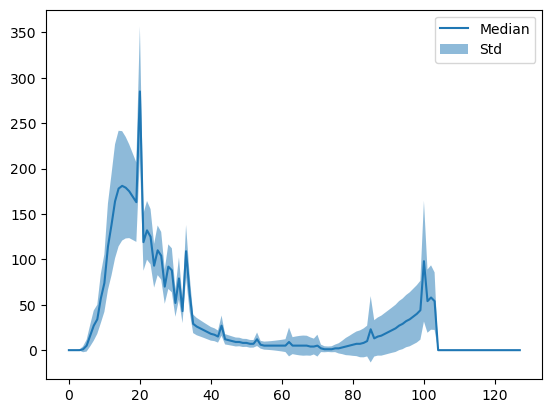

In [ ]:
x_grid = np.arange(len(rbc_source_transformed))
# plot the RBC data as median and std
rbc_transformed = df_transformed.filter(like="PLT_RAW_")
medians = rbc_transformed.median(axis=0)
stds = rbc_transformed.std(axis=0)

plt.figure()
plt.plot(x_grid, medians, label="Median")
plt.fill_between(x_grid, medians - stds, medians + stds, alpha=0.5, label="Std")
plt.legend()

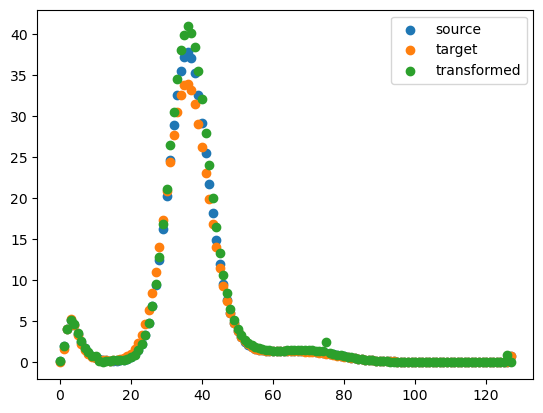

In [ ]:
x_grid = np.arange(len(rbc_source))
plt.scatter(x_grid, rbc_source / np.median(rbc_source), label="source")
plt.scatter(x_grid, rbc_target / np.median(rbc_target), label="target")
plt.scatter(
    x_grid,
    rbc_source_transformed / np.median(rbc_source_transformed),
    label="transformed",
)
plt.legend()

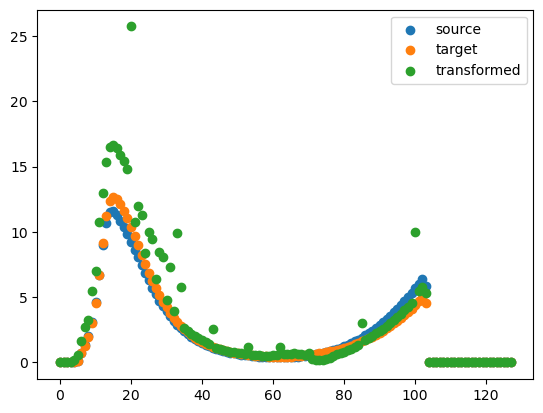

In [ ]:
x_grid = np.arange(len(plt_source))
plt.scatter(x_grid, plt_source / np.median(plt_source), label="source")
plt.scatter(x_grid, plt_target / np.median(plt_target), label="target")
plt.scatter(
    x_grid,
    plt_source_transformed / np.median(plt_source_transformed),
    label="transformed",
)
plt.legend()

In [15]:
from sklearn.mixture import GaussianMixture

In [16]:
plt_source.sum()

102147822

In [171]:
factor = 10_000 / plt_source.sum()
X_source = np.repeat(
    np.arange(len(plt_source)).reshape(-1, 1),
    (factor * plt_source.values).astype(int),
    axis=0,
)

In [172]:
gmm_source = GaussianMixture(
    n_components=2,
    covariance_type="full",
    n_init=20,
    # means_init=[
    #     # [20],
    #     # [60],
    #     # [100],
    #     # [80],
    # ],
    # verbose=1,
).fit(np.log(X_source + 1))

factor = 10_000 / plt_target.sum()
X_target = np.repeat(
    np.arange(len(plt_target)).reshape(-1, 1),
    (factor * plt_target.values).astype(int),
    axis=0,
)
gmm_target = GaussianMixture(
    n_components=2,
    covariance_type="full",
    n_init=20,
    # means_init=[
    #     [20],
    #     [60],
    #     # [100],
    #     # [80],
    # ],
    # verbose=1,
).fit(np.log(X_target + 1))

In [173]:
gmm_source.means_, gmm_target.means_

(array([[4.54363927],
        [3.08473386]]),
 array([[3.08507995],
        [4.53411578]]))

In [174]:
from sysmexalign.gmm_ot import compute_gmm_transport_map, transform_points_gmm

In [175]:
transport_dict = compute_gmm_transport_map(gmm_source, gmm_target)

In [176]:
print(np.matrix(transport_dict["omega"]).round(2))

[[0.05 0.24]
 [0.71 0.  ]]


In [177]:
transformed_imp = (
    np.exp(
        transform_points_gmm(
            np.log(X_source + 1), gmm_source, transport_dict, transport_method="rand"
        )
    )
    - 1
)

In [178]:
# transform to histogram with same bins as the original data (0 - 50)
transformed_hist, bins = np.histogram(transformed_imp, bins=np.arange(-0.5, 128.5))

In [179]:
bins

array([ -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,
         8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,
        17.5,  18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,
        26.5,  27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,
        35.5,  36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,
        44.5,  45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,
        53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,
        62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,
        71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,
        89.5,  90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,
        98.5,  99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5,
       107.5, 108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5,
       116.5, 117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5,
       125.5, 126.5,

/home/dk659/conda/envs/bloodcounts/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dk659/conda/envs/bloodcounts/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


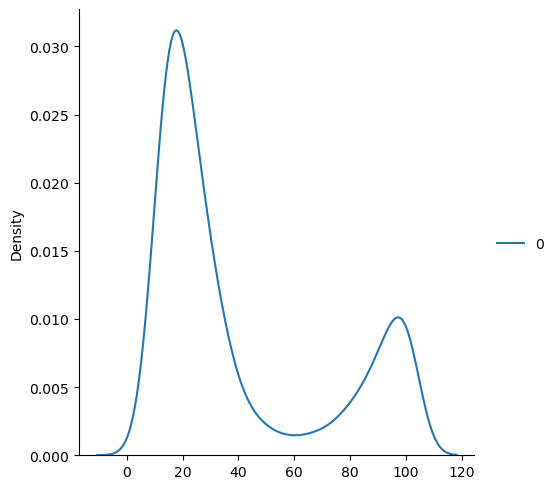

In [180]:
import seaborn as sns

sns.displot(transformed_imp, kind="kde")

In [181]:
transformed_hist

array([  0,   0,   0,   0,   1,   7,  36,  45,  77, 108, 156, 235, 301,
       360, 388, 398, 384, 375, 356, 340, 318, 302, 284, 264, 223, 231,
       224, 203, 154, 173, 153, 114, 143,  94, 203, 113,  63,  58,  52,
        48,  44,  40,  37,  34,  31,  28,  26,  24,  22,  21,  19,  18,
        17,  16,  29,  14,  13,  13,  12,  12,  12,  12,  12,  13,  13,
        15,  16,  19,  18,  21,  23,   4,  20,  21,  24,  21,  29,  37,
        32,  38,  37,  47,  48,  51,  54,   2,  54,  61,  64,  73,  81,
        91,  95, 100, 111, 116, 116,   0, 131, 140, 158, 157, 166, 148,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

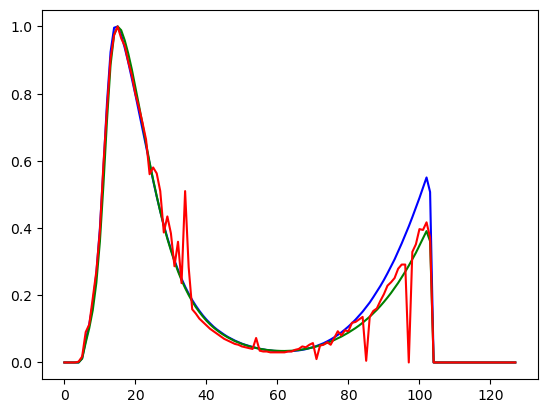

In [182]:
fig, ax = plt.subplots()
x_grid = np.arange(len(plt_source))
ax.plot(x_grid, plt_source / np.max(plt_source), color="blue")
ax.plot(x_grid, plt_target / np.max(plt_target), color="green")
ax.plot(x_grid, transformed_hist / np.max(transformed_hist), color="red")
# ax.set_xscale("log")

/home/dk659/conda/envs/bloodcounts/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dk659/conda/envs/bloodcounts/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Density'>

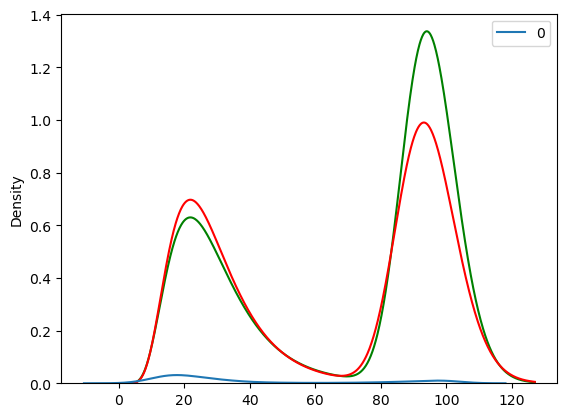

In [183]:
x_grid = np.linspace(1, 127, 1000)
fig, ax = plt.subplots()
y_source = np.exp(gmm_source.score_samples(np.log(x_grid.reshape(-1, 1))))
y_target = np.exp(gmm_target.score_samples(np.log(x_grid.reshape(-1, 1))))
ax.plot(x_grid, y_source, color="green")
ax.plot(x_grid, y_target, color="red")
# plt.plot(np.arange(0, 50), transformed_hist/np.max(transformed_hist), color="red")
sns.kdeplot(transformed_imp, color="blue", ax=ax)